In [63]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [102]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
from matplotlib import rc
rc('figure', figsize=(15, 5))
from timeit import default_timer as timer
import pickle
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Dense, Activation, Dropout, Reshape, Concatenate
from keras.layers.embeddings import Embedding
from keras.metrics import mean_squared_error
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam

In [0]:
sales_test = pd.read_csv(r'/content/gdrive/My Drive/Colab Notebooks/Time_series_prediction/test.csv')

In [0]:
def create_test(test):
    test = test.loc[(test['shop_id'].isin(sales_test['shop_id']))&(test['item_id'].isin(sales_test['item_id'])),:].copy()
    test_pred = test['cnt_shop_item'].copy()
    test.drop('cnt_shop_item', axis = 1, inplace = True)
    return(test, test_pred)

In [0]:
def create_cv_sets2(months, data):
    X_train = data.loc[~data['date_block_num'].isin(months+[34]),:].drop('cnt_shop_item', axis=1)
    X_val = data.loc[data['date_block_num'].isin(months),:]
    X_val, y_val = create_test(X_val)
    X_test = data.loc[data['date_block_num'] == 34,:].drop('cnt_shop_item',axis=1)
    y_train = data.loc[~data['date_block_num'].isin(months+[34]),'cnt_shop_item']
    return(dict({'train': X_train, 'val': X_val, 'test': X_test, 'train_y': y_train, 'val_y': y_val}))

In [0]:
def plot_learning_curve(model):
  plt.plot(model.history.history['val_loss'], label = 'validation')
  plt.plot(model.history.history['loss'], label = 'training')
  plt.legend()
  plt.title('Learning Curve')
  return(plt)

In [0]:
with open(r"/content/gdrive/My Drive/Colab Notebooks/Time_series_prediction/full_data_2.pkl", "rb") as input_file:
    full_data = pickle.load(input_file)

In [0]:
dict_cat = create_cv_sets2([9,21,33], full_data)

In [0]:
n_feats = [i for i in dict_cat['train'].columns.tolist() if i not in ['date_block_num', 'shop_id', 'item_id', 
                                                                      'item_category_id', 'month', 'year']]
for feat in n_feats:
    scaler = StandardScaler()
    dict_cat['train'][feat] = scaler.fit_transform(dict_cat['train'][feat].values.reshape(-1,1))
    dict_cat['val'][feat] = scaler.transform(dict_cat['val'][feat].values.reshape(-1,1))
    dict_cat['test'][feat] = scaler.transform(dict_cat['test'][feat].values.reshape(-1,1))

In [0]:
order_of_var = [
    'date_block_num',
    
    'shop_id_enc_cnt_shop_item', 'shop_id_enc_cnt_shop',
    'shop_id_enc_cnt_item', 'shop_id_enc_cnt_itcat',
    
    'item_id_enc_cnt_shop_item', 'item_id_enc_cnt_shop',
    'item_id_enc_cnt_item', 'item_id_enc_cnt_itcat',
    
    'item_category_id_enc_cnt_shop_item', 'item_category_id_enc_cnt_shop',
    'item_category_id_enc_cnt_item', 'item_category_id_enc_cnt_itcat',
    
    'month_enc_cnt_shop_item', 'month_enc_cnt_shop', 
    'month_enc_cnt_item', 'month_enc_cnt_itcat', 
    
    'year_enc_cnt_shop_item', 'year_enc_cnt_shop',
    'year_enc_cnt_item', 'year_enc_cnt_itcat',
    
    'sales_shop_item_lag_1', 'price_shop_item_lag_1', 
    'sales_shop_item_lag_2', 'price_shop_item_lag_2',
    'cnt_shop_item_lag_1', 'cnt_shop_item_lag_2',
    'cnt_shop_item_lag_3', 'cnt_shop_item_lag_4',
    'cnt_shop_item_lag_5', 'cnt_shop_item_lag_6',
    'cnt_shop_item_lag_12',
    
    'sales_shop_lag_1', 'price_shop_lag_1',
    'sales_shop_lag_2', 'price_shop_lag_2',
    'cnt_shop_lag_1', 'cnt_shop_lag_2',
    'cnt_shop_lag_3', 'cnt_shop_lag_4',
    'cnt_shop_lag_5', 'cnt_shop_lag_6',
    'cnt_shop_lag_12',
    
    'sales_item_lag_1', 'price_item_lag_1', 
    'sales_item_lag_2', 'price_item_lag_2',
    'cnt_item_lag_1', 'cnt_item_lag_2',
    'cnt_item_lag_3', 'cnt_item_lag_4',
    'cnt_item_lag_5', 'cnt_item_lag_6',
    'cnt_item_lag_12',
    
    'sales_itcat_lag_1', 'price_itcat_lag_1', 
    'sales_itcat_lag_2', 'price_itcat_lag_2',
    'cnt_itcat_lag_1', 'cnt_itcat_lag_2',
    'cnt_itcat_lag_3', 'cnt_itcat_lag_4',
    'cnt_itcat_lag_5', 'cnt_itcat_lag_6',
    'cnt_itcat_lag_12',
    
    'item_name_1', 'item_name_2', 
    'item_name_3', 'item_name_4', 
    'item_name_5', 
    
    'item_category_name_1', 'item_category_name_2', 
    'item_category_name_3', 'item_category_name_4',
    'item_category_name_5']

In [29]:
len(order_of_var)

75

In [0]:
def create_emb_df(mat):
    df = mat.copy()
    df['month']-=1
    df['year']-=2013
    X = []
    cat_ind = ['shop_id', 'item_id', 'item_category_id', 'month', 'year']
    for feat in cat_ind:
        X.append(df[feat].values)
    df = df.drop(cat_ind, axis = 1)
    freq_cat = [1,4,4,4,4,4,11,11,11,11,5,5]
    curr = 0
    for i in freq_cat:
        X.append(df.iloc[:,curr:(curr+i)].values)
        curr+=i
    return(X)

In [0]:
nn_dict = dict()
for key in dict_cat.keys():
    nn_dict[key] = create_emb_df(dict_cat[key]) if 'y' not in key else dict_cat[key].values

###*Creating a dense embedding neural network without Item Ids*

In [0]:
for key in nn_dict.keys():
    if 'y' not in key: del nn_dict[key][1]

In [0]:
def make_model_dense():
    
    layers = []
    
    shop_id_in = Input((1,), name = 'shop_id_in')
    shop_id = Embedding(60,12)(shop_id_in)
    shop_id = Reshape((12,))(shop_id)
    layers.append(shop_id)
    
    itcat_id_in = Input((1,), name='itcat_in')
    itcat_id = Embedding(84,12)(itcat_id_in)
    itcat_id = Reshape((12,))(itcat_id)
    layers.append(itcat_id)
    
    month_in = Input((1,), name='month_in')
    month = Embedding(12,4)(month_in)
    month = Reshape((4,))(month)
    layers.append(month)
    
    year_in = Input((1,), name='year_in')
    year = Embedding(3,2)(year_in)
    year = Reshape((2,))(year)
    layers.append(year)
    
    date_block_in = Input((1,), name='date_block_in')
    date_block = Dense(1)(date_block_in)
    layers.append(date_block)
    
    shop_id_enc_in = Input((4,), name='shop_id_end_in')
    shop_id_enc = Dense(4)(shop_id_enc_in)
    layers.append(shop_id_enc)
    
    item_id_enc_in = Input((4,), name='item_id_end_in')
    item_id_enc = Dense(4)(item_id_enc_in)
    layers.append(item_id_enc)
    
    itcat_id_enc_in = Input((4,), name='itcat_id_end_in')
    itcat_id_enc = Dense(4)(itcat_id_enc_in)
    layers.append(itcat_id_enc)
    
    month_id_enc_in = Input((4,), name='month_id_end_in')
    month_id_enc = Dense(4)(month_id_enc_in)
    layers.append(month_id_enc)
    
    year_id_enc_in = Input((4,), name='year_id_end_in')
    year_id_enc = Dense(4)(year_id_enc_in)
    layers.append(year_id_enc)
    
    shop_item_lag_in = Input((11,), name='shop_item_lag_in')
    shop_item_lag = Dense(11)(shop_item_lag_in)
    layers.append(shop_item_lag)
    
    shop_lag_in = Input((11,), name='shop_lag_in')
    shop_lag = Dense(11)(shop_lag_in)
    layers.append(shop_lag)
    
    item_lag_in = Input((11,), name='item_lag_in')
    item_lag = Dense(11)(item_lag_in)
    layers.append(item_lag)
    
    itcat_lag_in = Input((11,), name='itcat_lag_in')
    itcat_lag = Dense(11)(itcat_lag_in)
    layers.append(itcat_lag)
    
    item_name_in = Input((5,),name='item_name_in')
    item_name = Dense(5)(item_name_in)
    layers.append(item_name)
    
    itcat_name_in = Input((5,), name='itcat_name_in')
    itcat_name = Dense(5)(itcat_name_in)
    layers.append(itcat_name)
    
    model = Concatenate()(layers)
    model = Dropout(0.02)(model)
    
    model = Dense(1000, name='fc1')(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = Dropout(0.2)(model)
    
    model = Dense(500, name='fc2')(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = Dropout(0.2)(model)
    
    model = Dense(150, name='fc3')(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = Dropout(0.1)(model)
    
    model = Dense(15,name='fc4')(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = Dropout(0.1)(model)
    
    model= Dense(1,name='fc5')(model)
    
    final_model = Model(inputs = [shop_id_in, itcat_id_in, month_in, year_in, date_block_in, shop_id_enc_in,
                                 item_id_enc_in, itcat_id_enc_in, month_id_enc_in, year_id_enc_in, shop_item_lag_in,
                                 shop_lag_in, item_lag_in, itcat_lag_in, item_name_in, itcat_name_in],
                       outputs = model,
                       name = 'nn_enc_dense_pfs4')
    return(final_model)

In [39]:
model = make_model_dense()
model.compile('Adam', loss = 'mean_squared_error')
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
shop_id_in (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
itcat_in (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
month_in (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
year_in (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_

In [41]:
check_point = ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/Time_series_prediction/nn_bn_dp.hdf5', monitor='val_loss', verbose=5, save_best_only=True)
model.fit(x = nn_dict['train'], y = nn_dict['train_y'], batch_size=2048, epochs=50, 
          validation_data=(nn_dict['val'], nn_dict['val_y']), callbacks = [check_point])

Train on 1483908 samples, validate on 59742 samples
Epoch 1/50
1483908/1483908 [==============================] - 32s 22us/step - loss: 2.5803 - val_loss: 2.4938

Epoch 00001: val_loss improved from inf to 2.49381, saving model to /content/gdrive/My Drive/Colab Notebooks/Time_series_prediction/nn_bn_dp.hdf5
Epoch 2/50
1483908/1483908 [==============================] - 33s 22us/step - loss: 2.4560 - val_loss: 2.5148

Epoch 00002: val_loss did not improve from 2.49381
Epoch 3/50
1483908/1483908 [==============================] - 33s 22us/step - loss: 2.3746 - val_loss: 2.4222

Epoch 00003: val_loss improved from 2.49381 to 2.42217, saving model to /content/gdrive/My Drive/Colab Notebooks/Time_series_prediction/nn_bn_dp.hdf5
Epoch 4/50
1483908/1483908 [==============================] - 33s 22us/step - loss: 2.3097 - val_loss: 2.3989

Epoch 00004: val_loss improved from 2.42217 to 2.39890, saving model to /content/gdrive/My Drive/Colab Notebooks/Time_series_prediction/nn_bn_dp.hdf5
Epoch 5

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

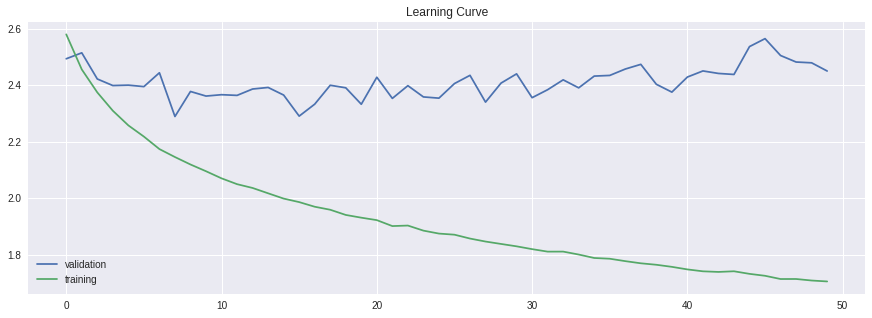

In [47]:
plot_learning_curve(model)

Deeper Network

In [0]:
def make_model_dense():
    
    layers = []
    
    shop_id_in = Input((1,), name = 'shop_id_in')
    shop_id = Embedding(60,12)(shop_id_in)
    shop_id = Reshape((12,))(shop_id)
    layers.append(shop_id)
    
    itcat_id_in = Input((1,), name='itcat_in')
    itcat_id = Embedding(84,12)(itcat_id_in)
    itcat_id = Reshape((12,))(itcat_id)
    layers.append(itcat_id)
    
    month_in = Input((1,), name='month_in')
    month = Embedding(12,4)(month_in)
    month = Reshape((4,))(month)
    layers.append(month)
    
    year_in = Input((1,), name='year_in')
    year = Embedding(3,2)(year_in)
    year = Reshape((2,))(year)
    layers.append(year)
    
    date_block_in = Input((1,), name='date_block_in')
    date_block = Dense(1)(date_block_in)
    layers.append(date_block)
    
    shop_id_enc_in = Input((4,), name='shop_id_end_in')
    shop_id_enc = Dense(4)(shop_id_enc_in)
    layers.append(shop_id_enc)
    
    item_id_enc_in = Input((4,), name='item_id_end_in')
    item_id_enc = Dense(4)(item_id_enc_in)
    layers.append(item_id_enc)
    
    itcat_id_enc_in = Input((4,), name='itcat_id_end_in')
    itcat_id_enc = Dense(4)(itcat_id_enc_in)
    layers.append(itcat_id_enc)
    
    month_id_enc_in = Input((4,), name='month_id_end_in')
    month_id_enc = Dense(4)(month_id_enc_in)
    layers.append(month_id_enc)
    
    year_id_enc_in = Input((4,), name='year_id_end_in')
    year_id_enc = Dense(4)(year_id_enc_in)
    layers.append(year_id_enc)
    
    shop_item_lag_in = Input((11,), name='shop_item_lag_in')
    shop_item_lag = Dense(11)(shop_item_lag_in)
    layers.append(shop_item_lag)
    
    shop_lag_in = Input((11,), name='shop_lag_in')
    shop_lag = Dense(11)(shop_lag_in)
    layers.append(shop_lag)
    
    item_lag_in = Input((11,), name='item_lag_in')
    item_lag = Dense(11)(item_lag_in)
    layers.append(item_lag)
    
    itcat_lag_in = Input((11,), name='itcat_lag_in')
    itcat_lag = Dense(11)(itcat_lag_in)
    layers.append(itcat_lag)
    
    item_name_in = Input((5,),name='item_name_in')
    item_name = Dense(5)(item_name_in)
    layers.append(item_name)
    
    itcat_name_in = Input((5,), name='itcat_name_in')
    itcat_name = Dense(5)(itcat_name_in)
    layers.append(itcat_name)
    
    model = Concatenate()(layers)
    model = Dropout(0.02)(model)
    
    model = Dense(1500, name='fc1')(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = Dropout(0.2)(model)
    
    model = Dense(1000, name='fc2')(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = Dropout(0.2)(model)
    
    model = Dense(500, name='fc3')(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = Dropout(0.1)(model)
    
    model = Dense(150, name='fc4')(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = Dropout(0.1)(model)
    
    model = Dense(15,name='fc5')(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = Dropout(0.1)(model)
    
    model= Dense(1,name='fc6')(model)
    
    final_model = Model(inputs = [shop_id_in, itcat_id_in, month_in, year_in, date_block_in, shop_id_enc_in,
                                 item_id_enc_in, itcat_id_enc_in, month_id_enc_in, year_id_enc_in, shop_item_lag_in,
                                 shop_lag_in, item_lag_in, itcat_lag_in, item_name_in, itcat_name_in],
                       outputs = model,
                       name = 'nn_enc_dense_pfs4')
    return(final_model)

In [56]:
model = make_model_dense()
model.compile('Adam', loss = 'mean_squared_error')
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
shop_id_in (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
itcat_in (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
month_in (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
year_in (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_

In [57]:
check_point = ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/Time_series_prediction/nn_bn_dp_deep.hdf5', monitor='val_loss', verbose=5, save_best_only=True)
model.fit(x = nn_dict['train'], y = nn_dict['train_y'], batch_size=2048, epochs=100, 
          validation_data=(nn_dict['val'], nn_dict['val_y']), callbacks = [check_point])

Train on 1483908 samples, validate on 59742 samples
Epoch 1/100
1483908/1483908 [==============================] - 46s 31us/step - loss: 2.9214 - val_loss: 2.7086

Epoch 00001: val_loss improved from inf to 2.70858, saving model to /content/gdrive/My Drive/Colab Notebooks/Time_series_prediction/nn_bn_dp_deep.hdf5
Epoch 2/100
1483908/1483908 [==============================] - 43s 29us/step - loss: 2.5316 - val_loss: 2.4545

Epoch 00002: val_loss improved from 2.70858 to 2.45446, saving model to /content/gdrive/My Drive/Colab Notebooks/Time_series_prediction/nn_bn_dp_deep.hdf5
Epoch 3/100
1483908/1483908 [==============================] - 43s 29us/step - loss: 2.4153 - val_loss: 2.3901

Epoch 00003: val_loss improved from 2.45446 to 2.39012, saving model to /content/gdrive/My Drive/Colab Notebooks/Time_series_prediction/nn_bn_dp_deep.hdf5
Epoch 4/100
1483908/1483908 [==============================] - 43s 29us/step - loss: 2.3351 - val_loss: 2.5668

Epoch 00004: val_loss did not improve f

In [0]:
model.save('/content/gdrive/My Drive/Colab Notebooks/Time_series_prediction/nn_last_model_bn_dp_deep.hdf')

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

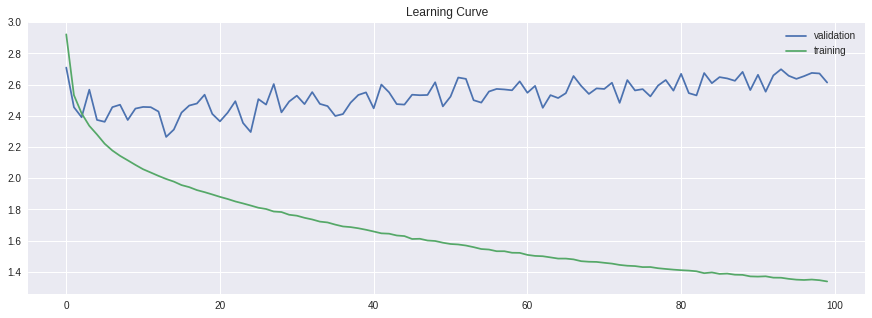

In [59]:
plot_learning_curve(model)

In [0]:
def make_model_dense():
    
    layers = []
    
    shop_id_in = Input((1,), name = 'shop_id_in')
    shop_id = Embedding(60,12)(shop_id_in)
    shop_id = Reshape((12,))(shop_id)
    layers.append(shop_id)
    
    itcat_id_in = Input((1,), name='itcat_in')
    itcat_id = Embedding(84,12)(itcat_id_in)
    itcat_id = Reshape((12,))(itcat_id)
    layers.append(itcat_id)
    
    month_in = Input((1,), name='month_in')
    month = Embedding(12,4)(month_in)
    month = Reshape((4,))(month)
    layers.append(month)
    
    year_in = Input((1,), name='year_in')
    year = Embedding(3,2)(year_in)
    year = Reshape((2,))(year)
    layers.append(year)
    
    date_block_in = Input((1,), name='date_block_in')
    date_block = Dense(1)(date_block_in)
    layers.append(date_block)
    
    shop_id_enc_in = Input((4,), name='shop_id_end_in')
    shop_id_enc = Dense(4)(shop_id_enc_in)
    layers.append(shop_id_enc)
    
    item_id_enc_in = Input((4,), name='item_id_end_in')
    item_id_enc = Dense(4)(item_id_enc_in)
    layers.append(item_id_enc)
    
    itcat_id_enc_in = Input((4,), name='itcat_id_end_in')
    itcat_id_enc = Dense(4)(itcat_id_enc_in)
    layers.append(itcat_id_enc)
    
    month_id_enc_in = Input((4,), name='month_id_end_in')
    month_id_enc = Dense(4)(month_id_enc_in)
    layers.append(month_id_enc)
    
    year_id_enc_in = Input((4,), name='year_id_end_in')
    year_id_enc = Dense(4)(year_id_enc_in)
    layers.append(year_id_enc)
    
    shop_item_lag_in = Input((11,), name='shop_item_lag_in')
    shop_item_lag = Dense(11)(shop_item_lag_in)
    layers.append(shop_item_lag)
    
    shop_lag_in = Input((11,), name='shop_lag_in')
    shop_lag = Dense(11)(shop_lag_in)
    layers.append(shop_lag)
    
    item_lag_in = Input((11,), name='item_lag_in')
    item_lag = Dense(11)(item_lag_in)
    layers.append(item_lag)
    
    itcat_lag_in = Input((11,), name='itcat_lag_in')
    itcat_lag = Dense(11)(itcat_lag_in)
    layers.append(itcat_lag)
    
    item_name_in = Input((5,),name='item_name_in')
    item_name = Dense(5)(item_name_in)
    layers.append(item_name)
    
    itcat_name_in = Input((5,), name='itcat_name_in')
    itcat_name = Dense(5)(itcat_name_in)
    layers.append(itcat_name)
    
    model = Concatenate()(layers)
    model = Dropout(0.02)(model)
    
    model = Dense(3000, name='fc1')(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = Dropout(0.2)(model)
    
    model = Dense(1500, name='fc2')(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = Dropout(0.2)(model)
    
    model = Dense(1000, name='fc3')(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = Dropout(0.1)(model)
    
    model = Dense(150, name='fc4')(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = Dropout(0.1)(model)
    
    model = Dense(15,name='fc5')(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = Dropout(0.1)(model)
    
    model= Dense(1,name='fc6')(model)
    
    final_model = Model(inputs = [shop_id_in, itcat_id_in, month_in, year_in, date_block_in, shop_id_enc_in,
                                 item_id_enc_in, itcat_id_enc_in, month_id_enc_in, year_id_enc_in, shop_item_lag_in,
                                 shop_lag_in, item_lag_in, itcat_lag_in, item_name_in, itcat_name_in],
                       outputs = model,
                       name = 'nn_enc_dense_pfs4')
    return(final_model)

In [96]:
model = make_model_dense()
model.compile('Adam', loss = 'mean_squared_error')
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
shop_id_in (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
itcat_in (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
month_in (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
year_in (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_

In [97]:
check_point = ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/Time_series_prediction/nn_bn_dp_deep2.hdf5', monitor='val_loss', verbose=5, save_best_only=True)
model.fit(x = nn_dict['train'], y = nn_dict['train_y'], batch_size=2048, epochs=100, 
          validation_data=(nn_dict['val'], nn_dict['val_y']), callbacks = [check_point])

Train on 1483908 samples, validate on 59742 samples
Epoch 1/100
1483908/1483908 [==============================] - 72s 48us/step - loss: 2.9623 - val_loss: 3.0501

Epoch 00001: val_loss improved from inf to 3.05005, saving model to /content/gdrive/My Drive/Colab Notebooks/Time_series_prediction/nn_bn_dp_deep2.hdf5
Epoch 2/100
1483908/1483908 [==============================] - 66s 44us/step - loss: 2.5458 - val_loss: 2.7126

Epoch 00002: val_loss improved from 3.05005 to 2.71259, saving model to /content/gdrive/My Drive/Colab Notebooks/Time_series_prediction/nn_bn_dp_deep2.hdf5
Epoch 3/100
1483908/1483908 [==============================] - 66s 44us/step - loss: 2.4267 - val_loss: 2.5657

Epoch 00003: val_loss improved from 2.71259 to 2.56573, saving model to /content/gdrive/My Drive/Colab Notebooks/Time_series_prediction/nn_bn_dp_deep2.hdf5
Epoch 4/100
1483908/1483908 [==============================] - 66s 44us/step - loss: 2.3375 - val_loss: 2.4896

Epoch 00004: val_loss improved from 

In [0]:
model.save('/content/gdrive/My Drive/Colab Notebooks/Time_series_prediction/nn_last_model_bn_dp0_deep2.hdf')

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

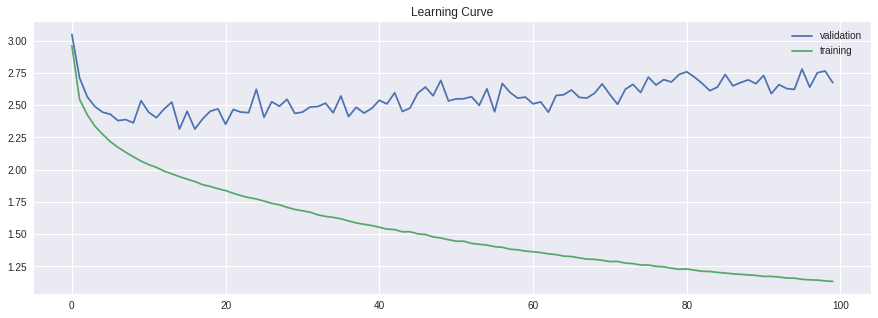

In [101]:
plot_learning_curve(model)